In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import linregress
from merge_data import merge_data

In [2]:
md, cd = merge_data()
md.head()

,Country,Year,HDI,Population,capacity_mw,cap_added,Region
0,Algeria,1990,0.577,25.758869,0.00,0.00,Africa
1,Argentina,1990,0.704,32.618651,761.02,761.02,South/Central America
2,Armenia,1990,0.631,3.538171,0.00,0.00,
3,Austria,1990,0.795,7.677850,13.00,13.00,Europe
4,Bahrain,1990,0.746,0.495931,0.00,0.00,


In [3]:
#import and format generation per capita data
generation_file = 'data/generation.csv'
gen_df = pd.read_csv(generation_file)
gen_df = gen_df.dropna()
gen_df=gen_df.rename(columns = {'Year':'Year', 'US':'US', 'Total So/Cent America':'South/Cent America', 
                                'Total Europe':'Europe', 'Total CIS':'CIS', 
                                'Total Middle East':'Middle East', 'Total Africa':'Africa', 
                                'Total Asia Pacific':'Asia Pacific', 'Total World':'World'})
gen_df.head()

,Year,US,South/Cent America,Europe,CIS,Middle East,Africa,Asia Pacific,World
0,1990,318.7,38.6,143.0,203.8,80.9,14.7,25.3,63.7
1,1991,315.2,38.9,140.1,199.2,82.2,14.3,26.1,63.1
2,1992,316.9,40.0,135.6,188.3,87.4,14.2,26.8,62.5
3,1993,320.3,40.8,132.4,174.6,87.8,13.9,27.8,62.1
4,1994,322.9,42.4,129.4,158.8,95.7,13.9,28.9,62.0


In [4]:
#import and format green data
green_file = 'data/green.csv'
green_df = pd.read_csv(green_file)
#green_df.set_index('Region')
green_df = green_df.drop(['Change 2018', '1990-2018','Change Oil',
 'Change Natural Gas',
 'Change Coal',
 'Change Nuclear energy',
 'Change Hydro electric',
 'Change Renewables'], axis=1)
list(green_df)
#df.drop(['Cochice', 'Pima'])
#green_df.drop(green_df.index[7])
green_df = green_df[green_df.Region != "Total World"]
green_df=green_df.rename(columns = {'Region':'Region','2018 Oil':'Oil','2018 Natural Gas':'Natural Gas',
                                '2018 Coal':'Coal','2018 Nuclear energy':'Nuclear Energy',
                                '2018 Hydro electric':'Hydro','2018 Renewables':'Renewables'})
green_df

,Region,Oil,Natural Gas,Coal,Nuclear Energy,Hydro,Renewables
0,US,920,703,317,192,65,104
1,Total So/Cent America,315,145,36,5,165,35
2,Total Europe,742,472,307,212,145,172
3,Total CIS,194,499,135,47,55,1
4,Total Middle East,412,476,8,2,3,2
5,Total Africa,191,129,101,3,30,7
6,Total Asia Pacific,1695,710,2841,125,389,225


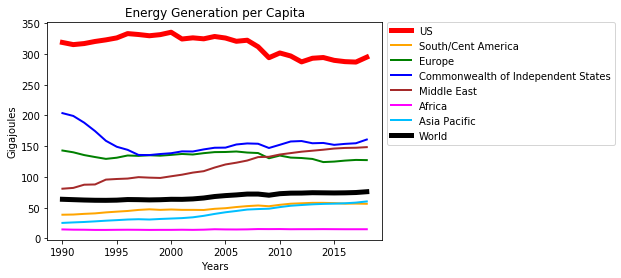

In [8]:
plt.plot(gen_df["Year"],gen_df["US"],color="red",linewidth=5,label="US")
plt.plot(gen_df["Year"],gen_df["South/Cent America"],color="orange",linewidth=2,label="South/Cent America")
plt.plot(gen_df["Year"],gen_df["Europe"],color="green",linewidth=2,label="Europe")
plt.plot(gen_df["Year"],gen_df["CIS"],color="blue",linewidth=2,label="Commonwealth of Independent States")
plt.plot(gen_df["Year"],gen_df["Middle East"],color="brown",linewidth=2,label="Middle East")
plt.plot(gen_df["Year"],gen_df["Africa"],color="fuchsia",linewidth=2,label ="Africa")
plt.plot(gen_df["Year"],gen_df["Asia Pacific"],color="deepskyblue",linewidth=2,label="Asia Pacific")
plt.plot(gen_df["Year"],gen_df["World"],color="black",linewidth=5,label="World")
plt.title("Energy Generation per Capita")
plt.xlabel("Years")
plt.ylabel("Gigajoules")
plt.legend(bbox_to_anchor=(1, 1.025))
plt.tight_layout
plt.savefig("Regional Energy Gen Over Time.png")

In [13]:
# define function to plot the linear regression line

def plot_linear_reg(country, color):
    x = np.linspace(1990, 2017, 3)
    result = linregress(gen_df['Year'], gen_df[country])
    y = result[0]*x+result[1]
    plt.plot(x, y, color=color, label=country)
    

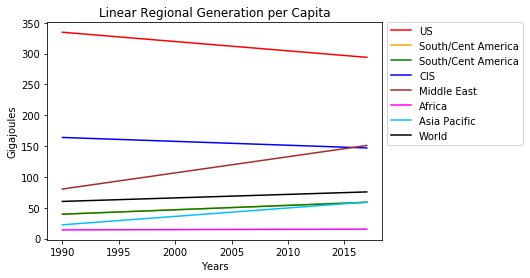

In [16]:
# graph and create png of linear regressions of Energy Generation By Region
plot_linear_reg('US', 'red')
plot_linear_reg('South/Cent America', 'orange')
plot_linear_reg('South/Cent America', 'green')
plot_linear_reg('CIS', 'blue')
plot_linear_reg('Middle East', 'brown')
plot_linear_reg('Africa', 'fuchsia')
plot_linear_reg('Asia Pacific', 'deepskyblue')
plot_linear_reg('World', 'black')

plt.title("Linear Regional Generation per Capita")
plt.xlabel("Years")
plt.ylabel("Gigajoules")
plt.legend(bbox_to_anchor=(1, 1.025))
plt.tight_layout
plt.savefig("Linear Regional Energy Gen Over Time.png")

In [ ]:
# make graph of linear models

plt.plot(gen_df["Year"],gen_df["US"],color="red",linewidth=5,label="US")
plt.plot(gen_df["Year"],gen_df["South/Cent America"],color="orange",linewidth=2,label="South/Cent America")
plt.plot(gen_df["Year"],gen_df["Europe"],color="green",linewidth=2,label="Europe")
plt.plot(gen_df["Year"],gen_df["CIS"],color="blue",linewidth=2,label="Commonwealth of Independent States")
plt.plot(gen_df["Year"],gen_df["Middle East"],color="brown",linewidth=2,label="Middle East")
plt.plot(gen_df["Year"],gen_df["Africa"],color="fuchsia",linewidth=2,label ="Africa")
plt.plot(gen_df["Year"],gen_df["Asia Pacific"],color="deepskyblue",linewidth=2,label="Asia Pacific")
plt.plot(gen_df["Year"],gen_df["World"],color="black",linewidth=5,label="World")
plt.title("Energy Generation per Capita")
plt.xlabel("Years")
plt.ylabel("Gigajoules")
plt.legend(bbox_to_anchor=(1, 1.025))
plt.tight_layout
plt.savefig("Regional Energy Gen Over Time.png")

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

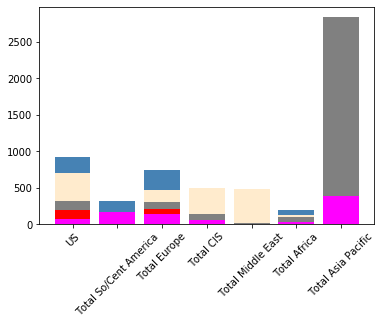

In [6]:
oil=green_df["Oil"]
gas=green_df["Natural Gas"]
coal=green_df["Coal"]
nuclear=green_df["Nuclear Energy"]
hydro=green_df["Hydro"]

plt.bar(green_df["Region"],oil,color="steelblue")
plt.bar(green_df["Region"],gas, color="blanchedalmond")
plt.bar(green_df["Region"],coal, color="gray")
plt.bar(green_df["Region"],nuclear,color="red")
plt.bar(green_df["Region"],hydro,color="fuchsia")

#green_df.pivot("Oil","Natural Gas","Coal").plot(kind='bar')

# plt.bar(green_df["Region"],oil,color="steelblue")
# plt.bar(green_df["Region"],gas,bottom=oil, color="blanchedalmond")
# plt.bar(green_df["Region"],coal,bottom=gas, color="gray")
# plt.bar(green_df["Region"],nuclear,bottom=coal,color="red")
# plt.bar(green_df["Region"],hydro,bottom=nuclear,color="fuchsia")

#plt.bar(green_d,color="rosybrodf["Region"],green_df["Natural Gas]",bottom=green_df["Oil"],color="rosybrown")
plt.xticks(rotation=45)

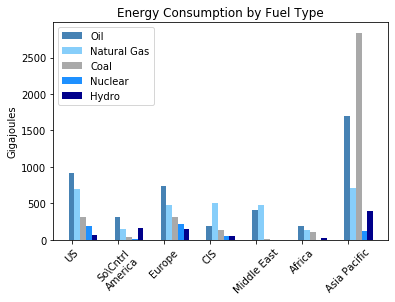

In [7]:
N = 7
# menMeans = (150*cm, 160*cm, 146*cm, 172*cm, 155*cm)
# menStd = (20*cm, 30*cm, 32*cm, 10*cm, 20*cm)

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.125         # the width of the bars
p1 = ax.bar(ind, oil, width, bottom=0,color="steelblue")
p2 = ax.bar(ind + width, gas, width, bottom=0,color="lightskyblue")
p3 = ax.bar(ind + width*2, coal, width, bottom=0,color="darkgray")
p4 = ax.bar(ind + width*3, nuclear, width, bottom=0,color="dodgerblue")
p5 = ax.bar(ind + width*4, hydro, width, bottom=0,color="darkblue")


ax.set_title('Energy Consumption by Fuel Type')
ax.set_xticks(ind + width / 10)
ax.set_xticklabels(('US', 'So\Cntrl\nAmerica', 'Europe', 'CIS', 'Middle East','Africa', 'Asia Pacific'),rotation=45)

ax.legend((p1[0], p2[0],p3[0], p4[0],p5[0]), ('Oil', 'Natural Gas','Coal','Nuclear','Hydro'))
ax.set_ylabel("Gigajoules")
#ax.yaxis.set_units("Gigajoules")
#ax.autoscale_view()

plt.show()